**EDA**
We shall try to identify:

- **class imbalance** in `loan_status`.
- Understand distributions of both numeric and categorical features.
- Find potential **relationships between features and loan default**.
- Create a **correlation matrix** to guide feature selection.

These insights will help shape our **feature selection**, **data preprocessing**, and **modeling strategy** in the next steps.

First we import necessary libraries and load the **feature-engineered LendingClub dataset** using the path stored in the configuration file. This ensures consistency and centralized control of file paths.

- We preview the shape and first few rows using `df.head()` to ensure the dataset is loaded correctly.
- This featured dataset includes only the relevant and cleaned columns ready for exploratory analysis.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Set seaborn style
sns.set(style='whitegrid')

# Load data path from config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load the featured dataset
file_path = config['featured_data_path']
df = pd.read_csv(file_path)
print("Dataset loaded. Shape:", df.shape)
# Preview Data
df.head()

Dataset loaded. Shape: (1344079, 22)


,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,fico_range_low,fico_range_high,loan_status,credit_history_years
0,3600.0,36,13.99,123.03,C,10.0,MORTGAGE,55000.0,Not Verified,debt_consolidation,...,1.0,7.0,0.0,2765.0,29.7,13.0,675.0,679.0,0,22
1,24700.0,36,11.99,820.28,C,10.0,MORTGAGE,65000.0,Not Verified,small_business,...,4.0,22.0,0.0,21470.0,19.2,38.0,715.0,719.0,0,26
2,20000.0,60,10.78,432.66,B,10.0,MORTGAGE,63000.0,Not Verified,home_improvement,...,0.0,6.0,0.0,7869.0,56.2,18.0,695.0,699.0,0,25
3,10400.0,60,22.45,289.91,F,3.0,MORTGAGE,104433.0,Source Verified,major_purchase,...,3.0,12.0,0.0,21929.0,64.5,35.0,695.0,699.0,0,27
4,11950.0,36,13.44,405.18,C,4.0,RENT,34000.0,Source Verified,debt_consolidation,...,0.0,5.0,0.0,8822.0,68.4,6.0,690.0,694.0,0,38


We check class imbalance before modeling. Imbalance (e.g. 80-20) may require sampling or reweighting. We visualize the distribution of the target variable `loan_status`.

- **0** = Fully Paid
- **1** = Charged Off (i.e. defaulted)

This is important because:
- If one class dominates (e.g., 90% fully paid), models may be biased.
- We may need **resampling or class weighting** in modeling.

Class distribution (counts):
 loan_status
0    1075771
1     268308
Name: count, dtype: int64

Class distribution (%):
 loan_status
0    80.037781
1    19.962219
Name: proportion, dtype: float64


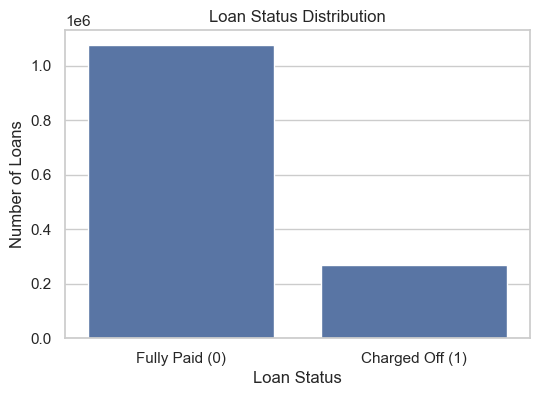

In [4]:
# Check distribution of target variable
class_counts = df['loan_status'].value_counts()
class_percent = df['loan_status'].value_counts(normalize=True) * 100

print("Class distribution (counts):\n", class_counts)
print("\nClass distribution (%):\n", class_percent)

# Visual
plt.figure(figsize=(6,4))
sns.countplot(x='loan_status', data=df)
plt.title("Loan Status Distribution")
plt.xticks([0, 1], ['Fully Paid (0)', 'Charged Off (1)'])
plt.ylabel("Number of Loans")
plt.xlabel("Loan Status")
plt.show()

Distribution of Numerical Features
We plot histograms of all numeric features (excluding the target):

- Helps identify **skewness**, **outliers**, and **spread**.
- Important for choosing **scaling strategies** for models (e.g., StandardScaler).
- Can also suggest log transformation (if highly skewed).

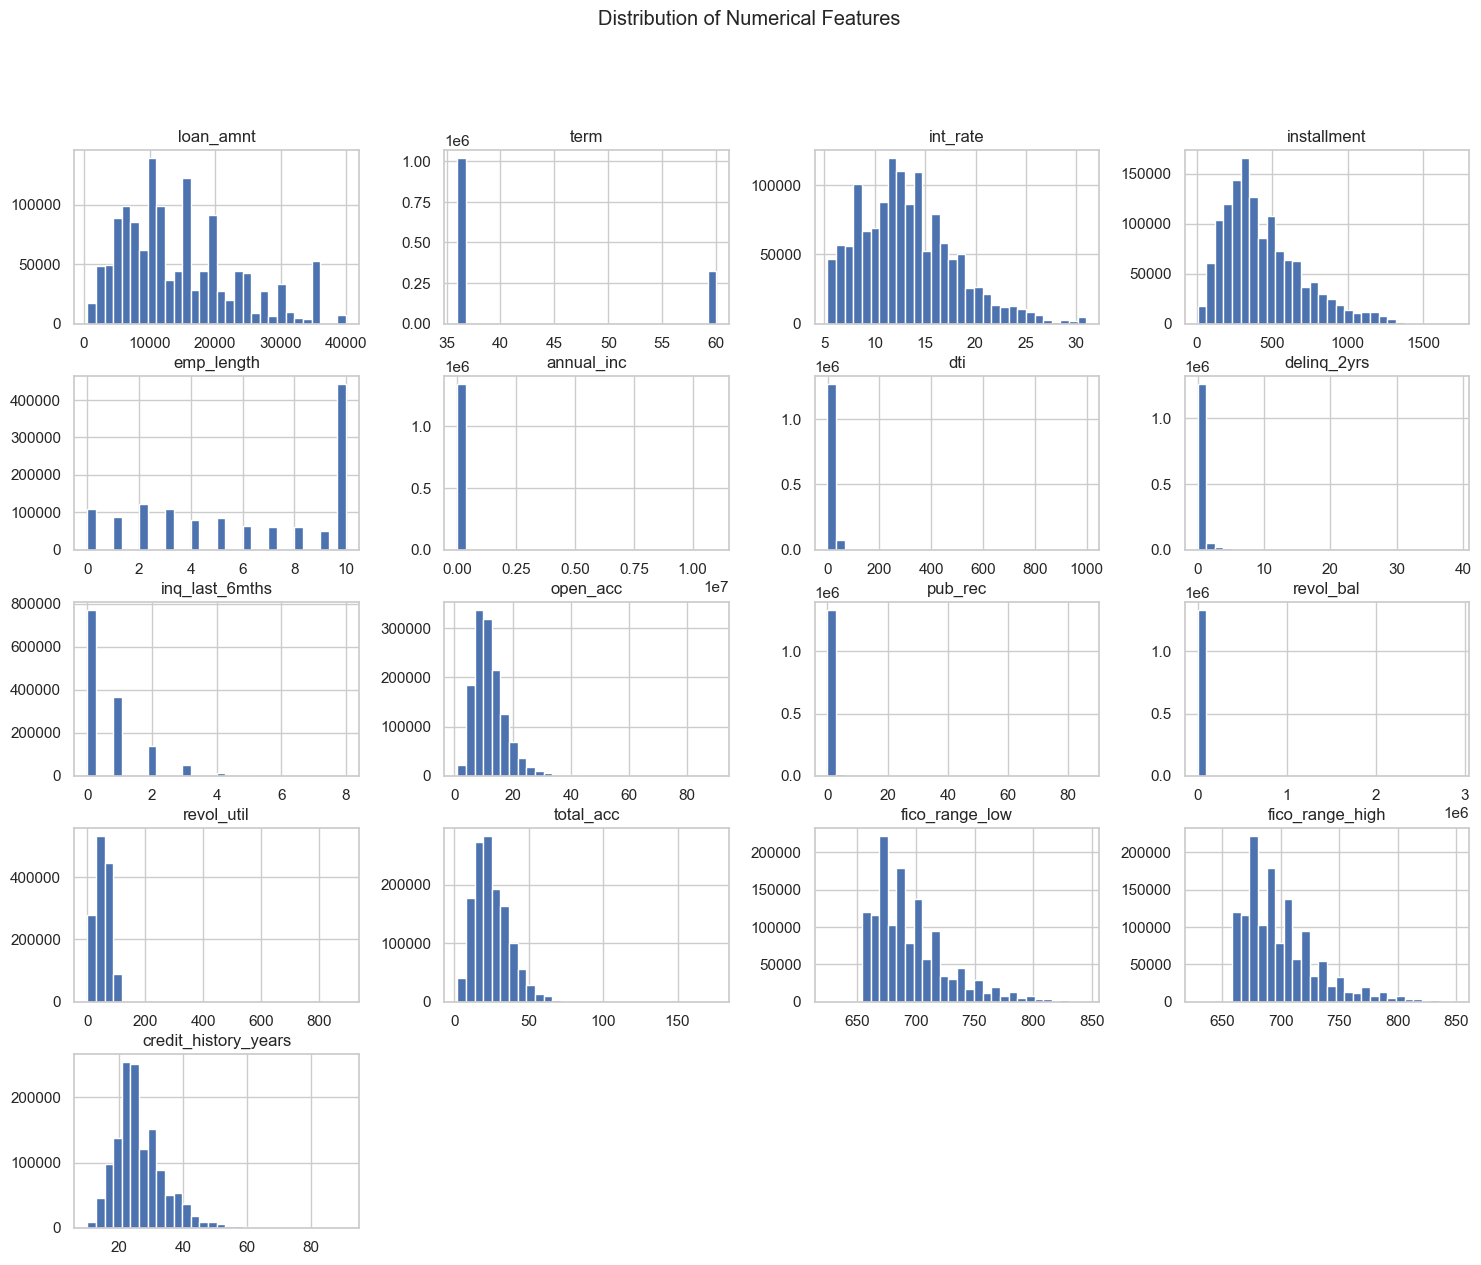

In [5]:
# Numerical columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('loan_status')  # exclude target

# Histograms
df[num_cols].hist(bins=30, figsize=(18, 14))
plt.suptitle("Distribution of Numerical Features")
plt.show()


Categorical Feature Distributions
We examine how often each category appears in variables like:

- `grade`
- `purpose`
- `home_ownership`
- `verification_status`

This helps:
- Identify **dominant classes**.
- Spot **imbalanced categories** that may need grouping or encoding.

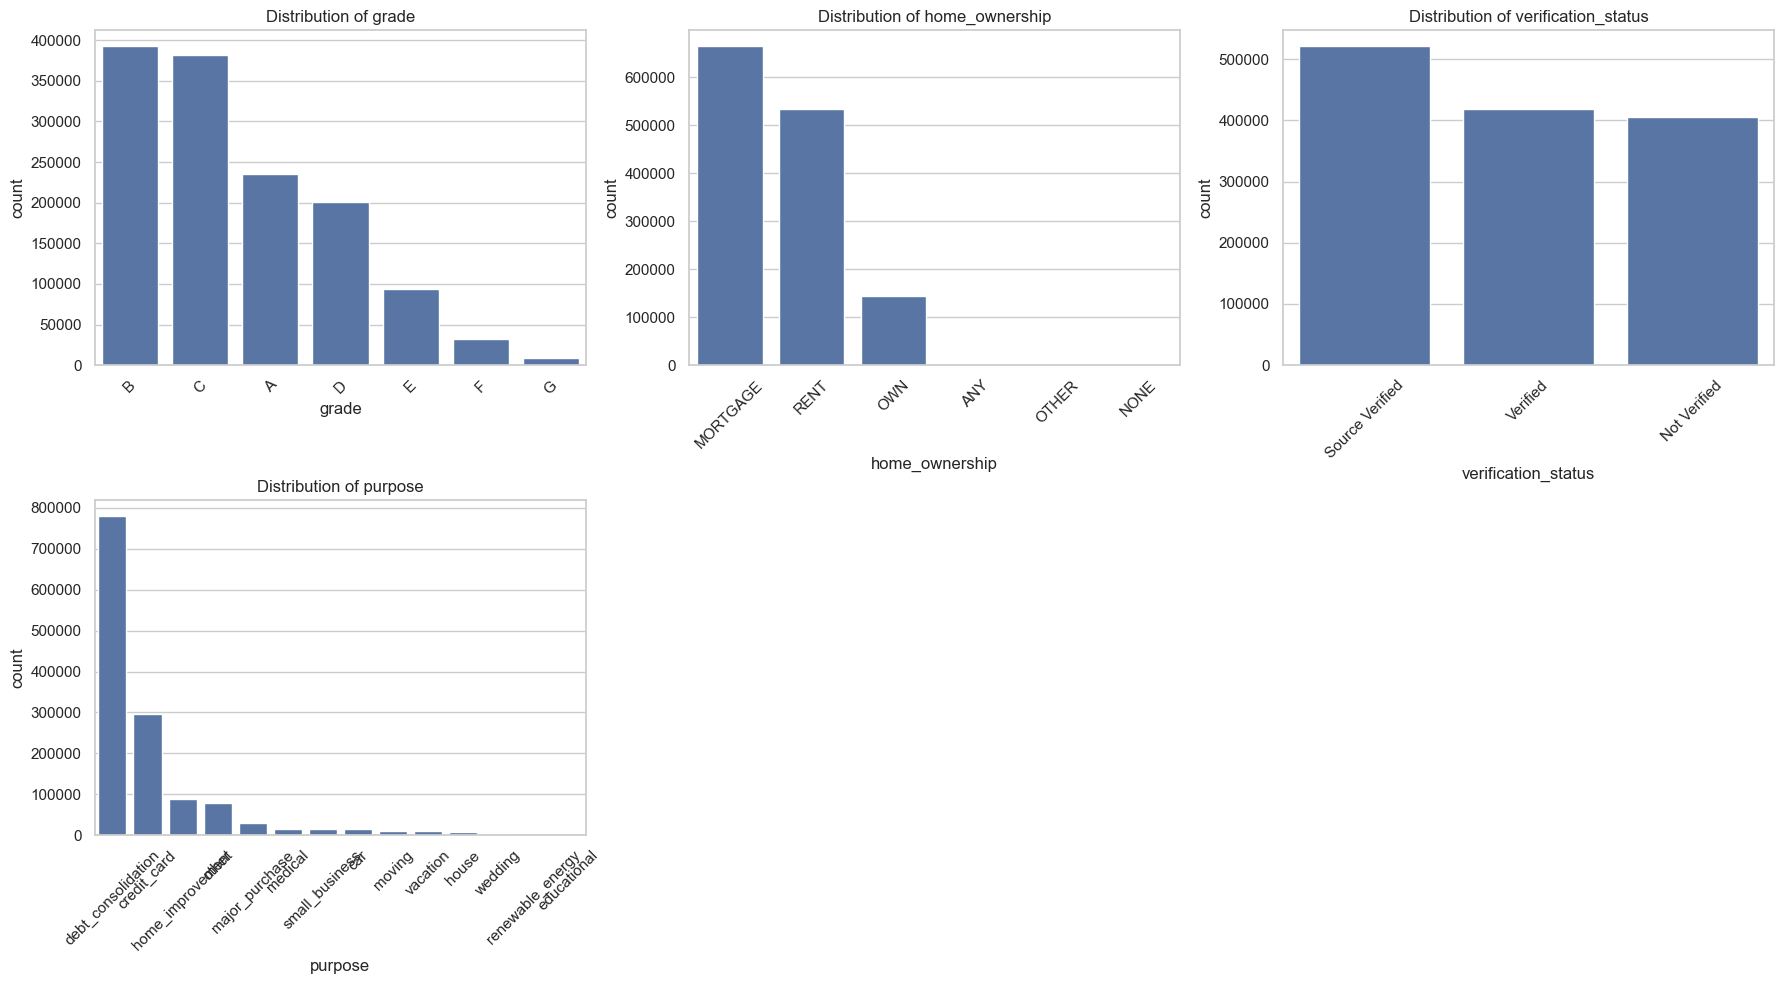

In [6]:
# Categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Bar plots
plt.figure(figsize=(18, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Relationship Between Features and Target
We analyze how features relate to `loan_status`.

- Boxplots (like `int_rate`) help check if **defaulted loans had higher interest rates**.
- Grouped bar plots (like `purpose`) help find **high-risk categories**.

This helps with **feature importance** and potential **risk segmentation**.

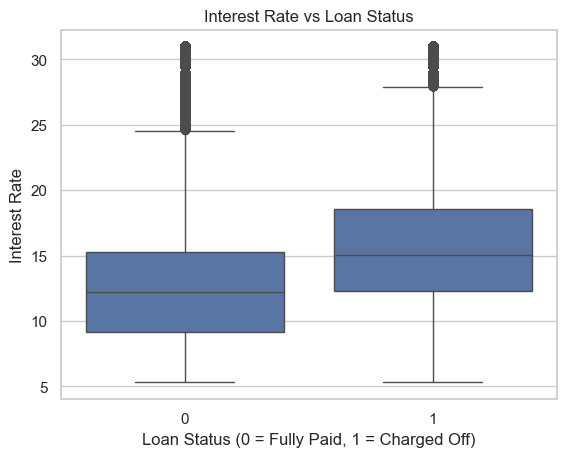

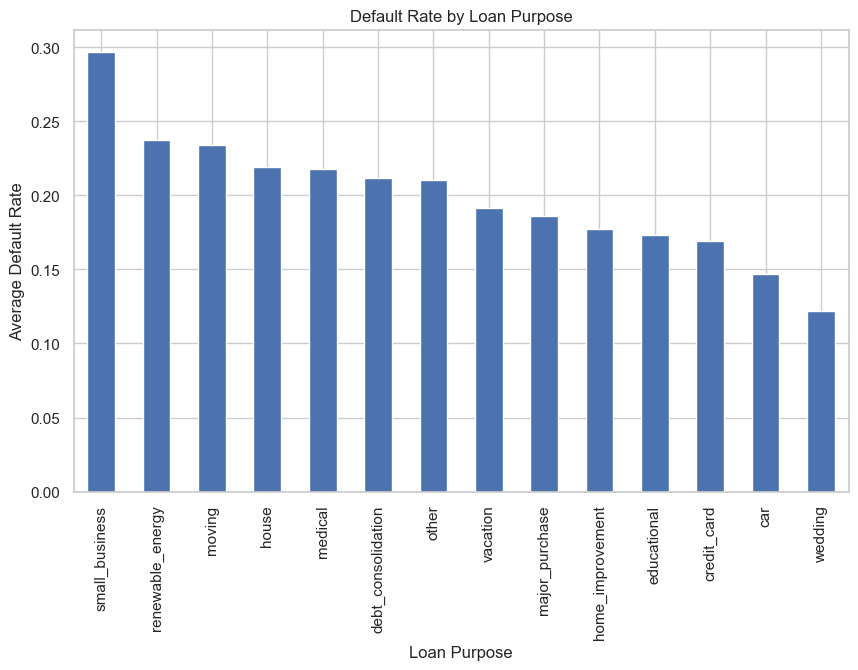

In [11]:
# Boxplot of interest rate vs loan status
sns.boxplot(x='loan_status', y='int_rate', data=df)
plt.title('Interest Rate vs Loan Status')
plt.xlabel('Loan Status (0 = Fully Paid, 1 = Charged Off)')
plt.ylabel('Interest Rate')
plt.show()

# Grouped mean default rate by purpose
purpose_default_rate = df.groupby('purpose')['loan_status'].mean().sort_values(ascending=False)
purpose_default_rate.plot(kind='bar', figsize=(10, 6))
plt.title('Default Rate by Loan Purpose')
plt.ylabel('Average Default Rate')
plt.xlabel('Loan Purpose')
plt.show()

ValueError: num must be an integer with 1 <= num <= 12, not 13

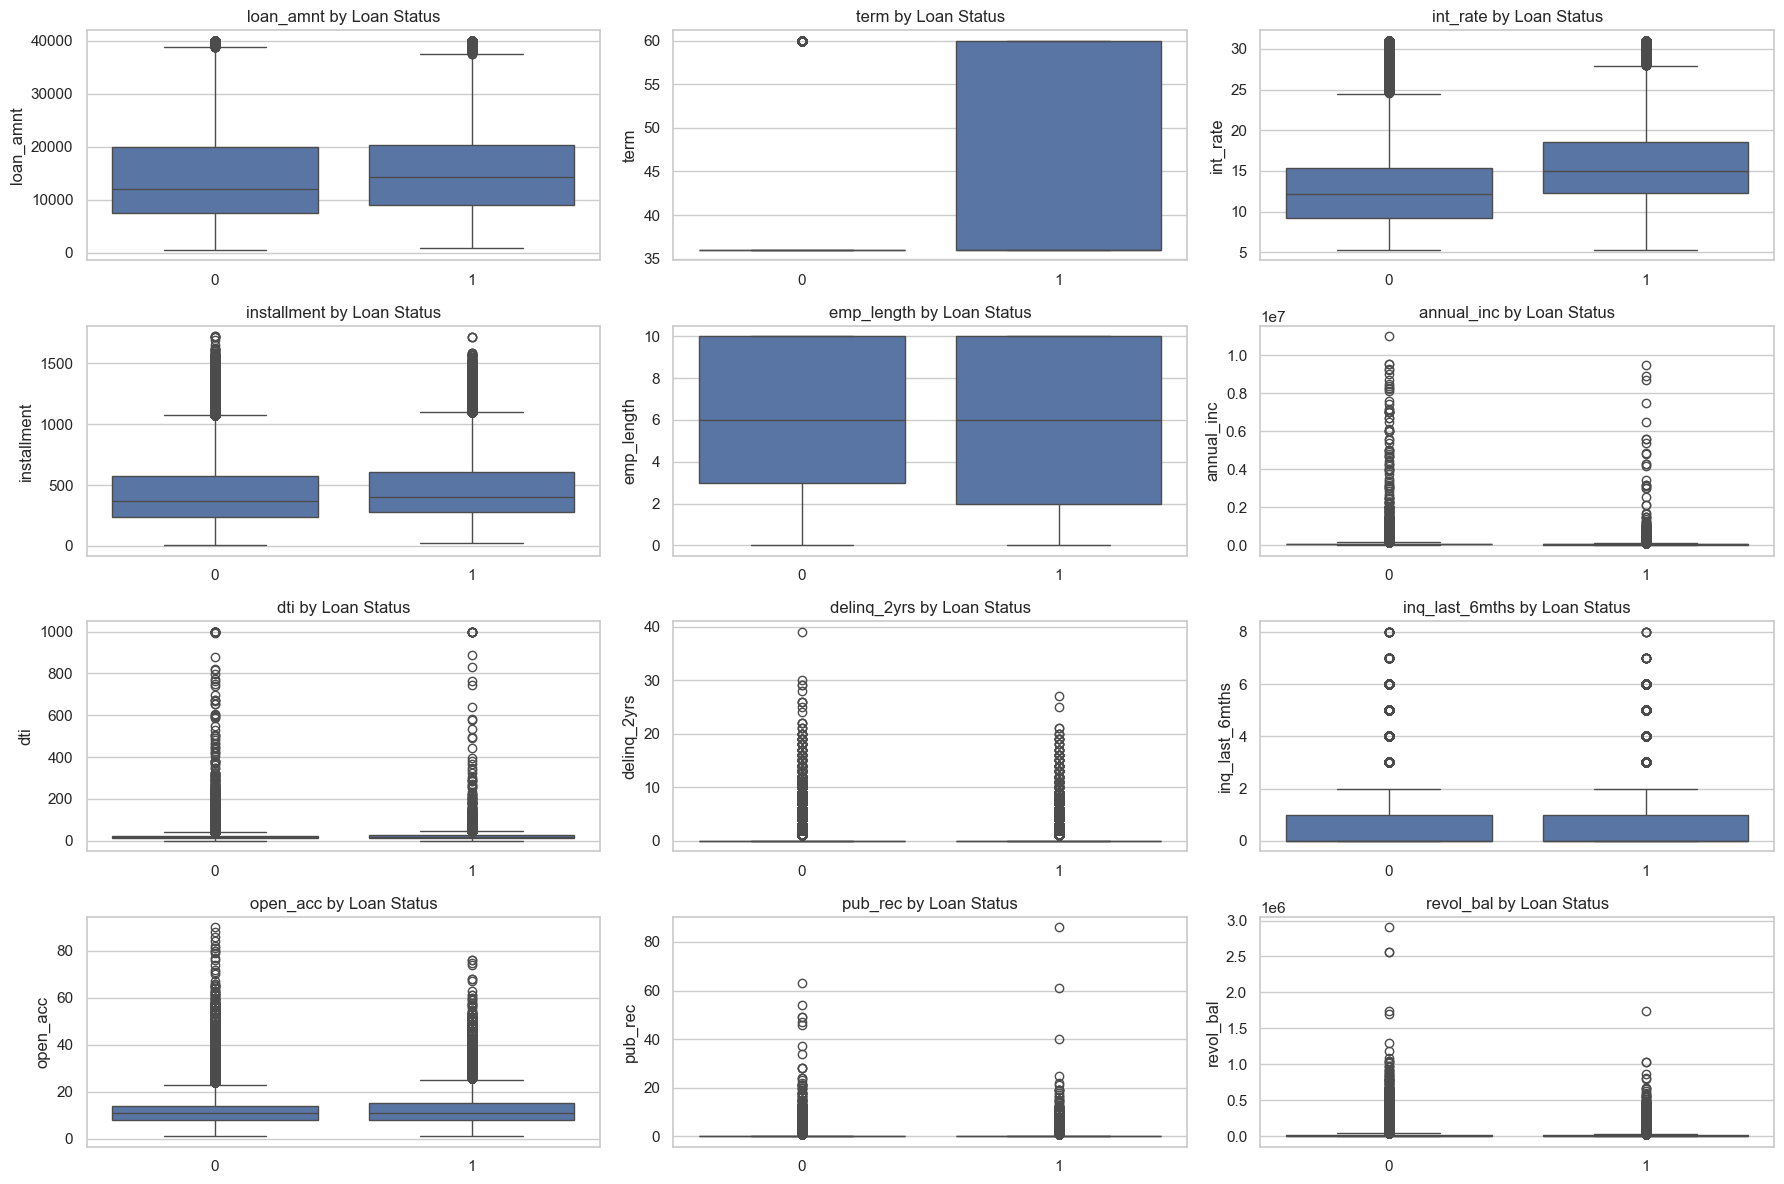

In [12]:
# Boxplots of numerical features grouped by loan_status
plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='loan_status', y=col, data=df)
    plt.title(f"{col} by Loan Status")
    plt.xlabel("")
    plt.tight_layout()
plt.show()


In [14]:
# Outlier detection using IQR
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"{col}: {outliers} outliers ({outliers/len(df)*100:.2f}%)")


loan_amnt: 7125 outliers (0.53%)
term: 324254 outliers (24.12%)
int_rate: 24923 outliers (1.85%)
installment: 41978 outliers (3.12%)
emp_length: 0 outliers (0.00%)
annual_inc: 65786 outliers (4.89%)
dti: 5483 outliers (0.41%)
delinq_2yrs: 258965 outliers (19.27%)
inq_last_6mths: 71385 outliers (5.31%)
open_acc: 46104 outliers (3.43%)
pub_rec: 227799 outliers (16.95%)
revol_bal: 79608 outliers (5.92%)
revol_util: 72 outliers (0.01%)
total_acc: 22610 outliers (1.68%)
fico_range_low: 46422 outliers (3.45%)
fico_range_high: 46422 outliers (3.45%)
loan_status: 268308 outliers (19.96%)
credit_history_years: 41249 outliers (3.07%)


In [15]:
# Summary statistics for skewed features
print("Skewness of numerical features:")
print(df[num_cols].skew().sort_values(ascending=False))

Skewness of numerical features:
annual_inc              46.425627
dti                     27.121836
revol_bal               13.759998
pub_rec                 11.554780
delinq_2yrs              5.606483
inq_last_6mths           1.695617
open_acc                 1.297792
fico_range_high          1.286317
fico_range_low           1.286123
term                     1.209585
credit_history_years     1.009088
installment              1.006516
total_acc                0.957272
loan_amnt                0.782384
int_rate                 0.713499
revol_util              -0.036441
emp_length              -0.217267
dtype: float64


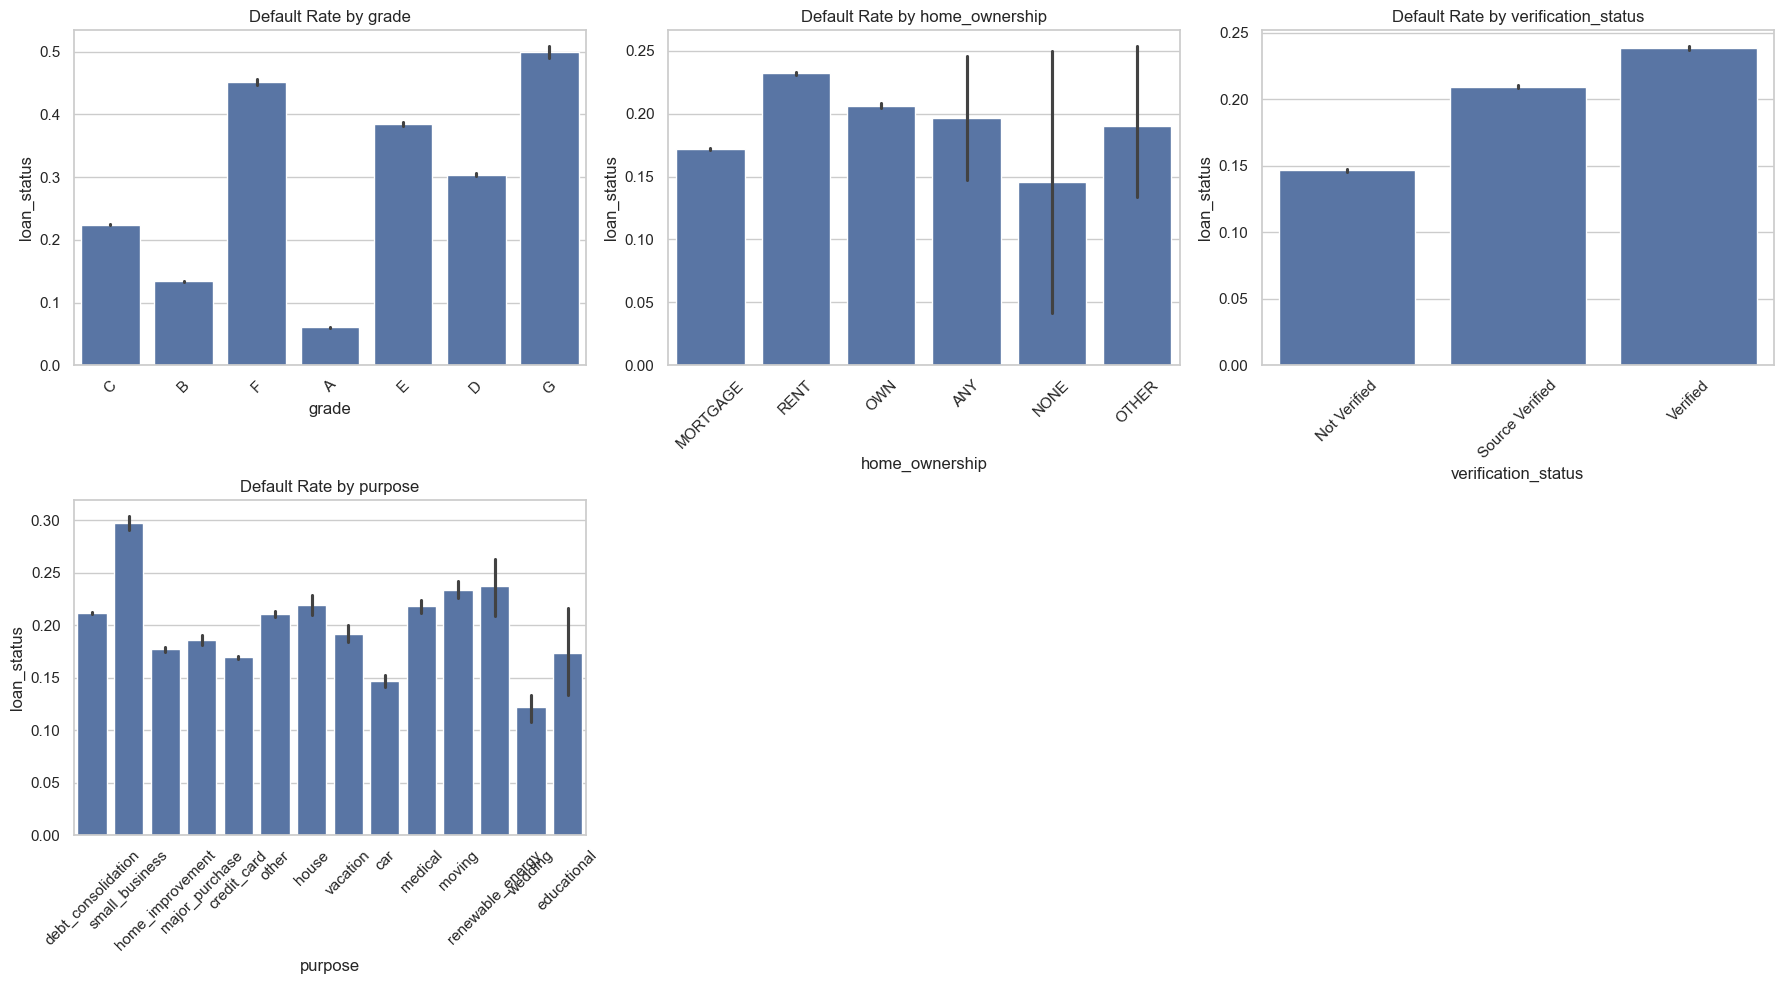

In [8]:
# Loan default rate across categories
plt.figure(figsize=(18, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=col, y='loan_status', data=df)
    plt.title(f"Default Rate by {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
from scipy.stats import chi2_contingency

cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    contingency_table = pd.crosstab(df[col], df['loan_status'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"{col}: p-value={p:.5f}")


grade: p-value=0.00000
home_ownership: p-value=0.00000
verification_status: p-value=0.00000
purpose: p-value=0.00000
fico_bin: p-value=0.00000


Correlation Between Features
We generate a **correlation matrix** to see how numerical features relate.

- High correlation (>0.9) may indicate **redundancy**.
- Strong correlation with `loan_status` may indicate **predictive power**.

This can guide **feature selection** and help avoid **multicollinearity**.

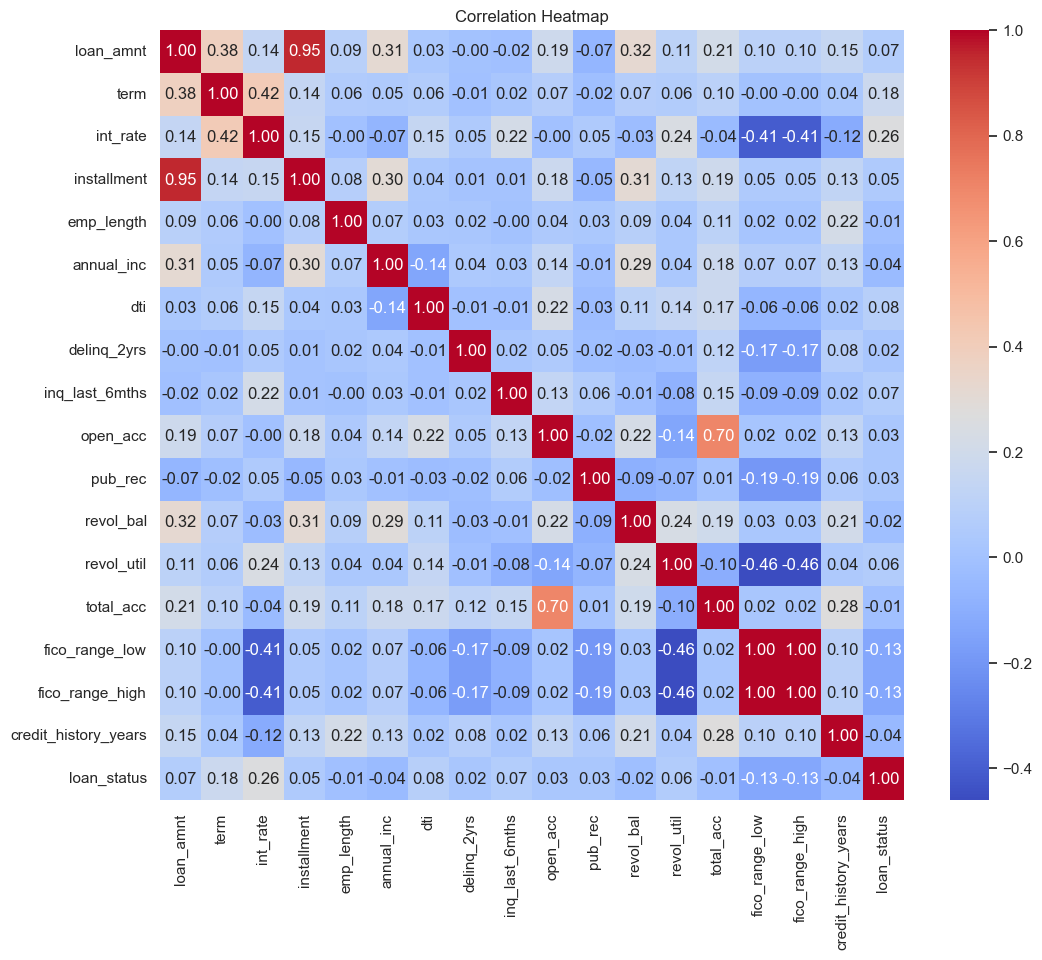

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr = df[num_cols + ['loan_status']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## Insights from EDA

Our exploratory analysis of the LendingClub dataset has yielded several important findings:

### Class Balance
- The dataset is **imbalanced**, with a higher proportion of "Fully Paid" loans compared to "Charged Off" loans.
- This will require handling (e.g., SMOTE, class weights) to ensure fair model performance.

### Numerical Feature Insights
- **Interest Rate**: Higher rates are associated with higher default probability.
- **FICO Scores**: Lower scores have significantly higher default rates.
- **Annual Income**: Heavily skewed with some extreme outliers — log transformation may be beneficial.
- **Loan Amount**: Slight upward trend in default risk with higher amounts, but not strongly linear.
- **DTI (Debt-to-Income ratio)**: Higher DTI correlates with higher default probability.

### Categorical Feature Insights
- **Purpose**: "Small business" and "debt consolidation" loans have higher default rates.
- **Home Ownership**: Not strongly predictive, though `OTHER` and `NONE` categories show slightly higher risk.
- **Grade**: Clear separation — lower grades (F, G) have much higher default rates.

### Correlation Analysis
- `fico_range_low` and `fico_range_high` are highly correlated (redundant — drop one).
- Most other numerical features show low-to-moderate correlation.

### Outlier Detection
- Significant outliers detected in `annual_inc`, `dti`, and `loan_amnt`.
- These may need capping or transformation to avoid model distortion.

### Statistical Tests
- Chi-square tests show strong associations between `loan_status` and features such as `grade`, `purpose`, and `verification_status`.

---

## Next we shall aim for:
1. **Preprocessing**:  
   - Handle imbalance, missing values, and outliers.  
   - Drop redundant features (`fico_range_low` or `fico_range_high`).  
   - Transform skewed variables.
2. **Encoding**:  
   - Convert categorical variables to numerical form.
3. **Modeling**:  
   - Start with baseline models (Logistic Regression, Random Forest).
4. **Evaluation**:  
   - Use metrics like ROC-AUC, F1-score due to class imbalance.
